In [37]:
import numpy as np
import pandas as pd
from scipy.special import expit
from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:


def simulate_data(n=10000, seed=42):
    np.random.seed(seed)

    age = np.random.randint(18, 70, size=n)
    purchase_freq = np.random.poisson(lam=2, size=n)
    avg_spend = np.random.gamma(shape=2, scale=50, size=n)
    gender = np.random.binomial(1, 0.5, size=n)
    region = np.random.choice(['Urban','Suburban','Rural'], size=n, p=[0.5,0.3,0.2])
    treatment = np.random.binomial(1, 0.5, size=n)

    region_effect = np.array([{'Urban':0.3,'Suburban':0.2,'Rural':0.0}[r] for r in region])

    # Baseline log odds for subscribing → now we want expected *spend*
    base_purchase = (
        20  # base spend
        + 1.5 * purchase_freq
        + 0.05 * avg_spend
        - 0.2 * age
        + 2 * gender
        + 10 * region_effect
    )

    # Treatment effect is heterogeneous — older customers benefit more
    treatment_effect = 15 + 10 * (age > 50) + 0.05 * avg_spend  # add small continuous variation

    # Total spend in next 7 days
    spend = base_purchase + treatment * treatment_effect + np.random.normal(0, 10, size=n)

    df = pd.DataFrame({
        'age': age,
        'purchase_freq': purchase_freq,
        'avg_spend': avg_spend,
        'gender': gender,
        'region': region,
        'treatment': treatment,
        'spend_7d': spend,
        'true_tau': treatment_effect
    })

    return df

df = simulate_data()
print(df.head())


   age  purchase_freq   avg_spend  gender    region  treatment   spend_7d  \
0   56              1  299.012058       0     Urban          0  22.798567   
1   69              2  263.880956       0  Suburban          0  19.329437   
2   46              0  106.485041       0     Urban          0  15.513652   
3   32              4   17.981340       0  Suburban          0  23.322620   
4   60              2   51.407621       1     Urban          1  58.272624   

    true_tau  
0  39.950603  
1  38.194048  
2  20.324252  
3  15.899067  
4  27.570381  


In [32]:
print(df.columns)

Index(['age', 'purchase_freq', 'avg_spend', 'gender', 'region', 'treatment',
       'spend_7d', 'true_tau'],
      dtype='object')


In [38]:
print("\nTreatment split:")
print(df['treatment'].value_counts(normalize=True))

print("\nSpend 7D stats:")
print(df['spend_7d'].describe())


Treatment split:
treatment
1    0.5047
0    0.4953
Name: proportion, dtype: float64

Spend 7D stats:
count    10000.000000
mean        34.136625
std         16.954554
min        -19.703068
25%         21.678988
50%         33.420175
75%         46.172614
max        106.105950
Name: spend_7d, dtype: float64


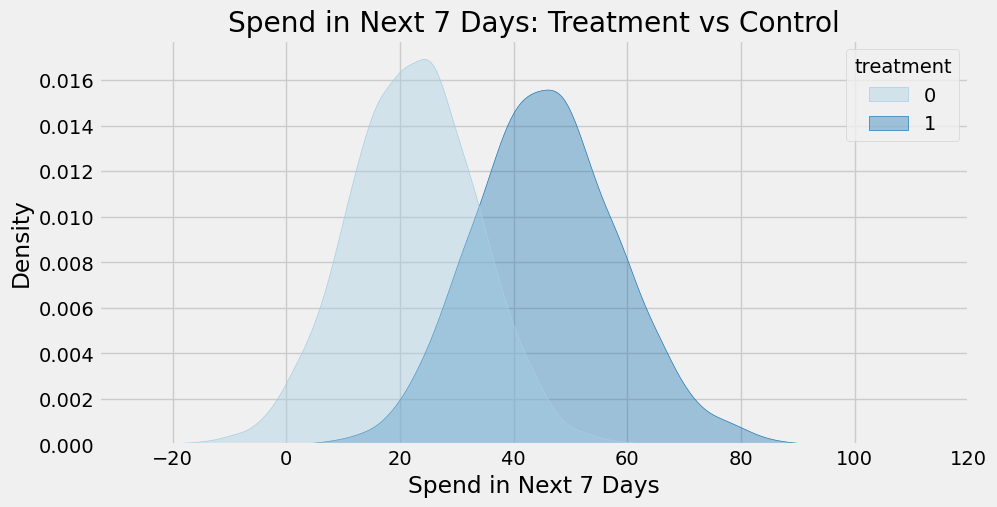

In [39]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='spend_7d', hue='treatment', fill=True, alpha=0.4)
plt.title('Spend in Next 7 Days: Treatment vs Control')
plt.xlabel('Spend in Next 7 Days')
plt.show()

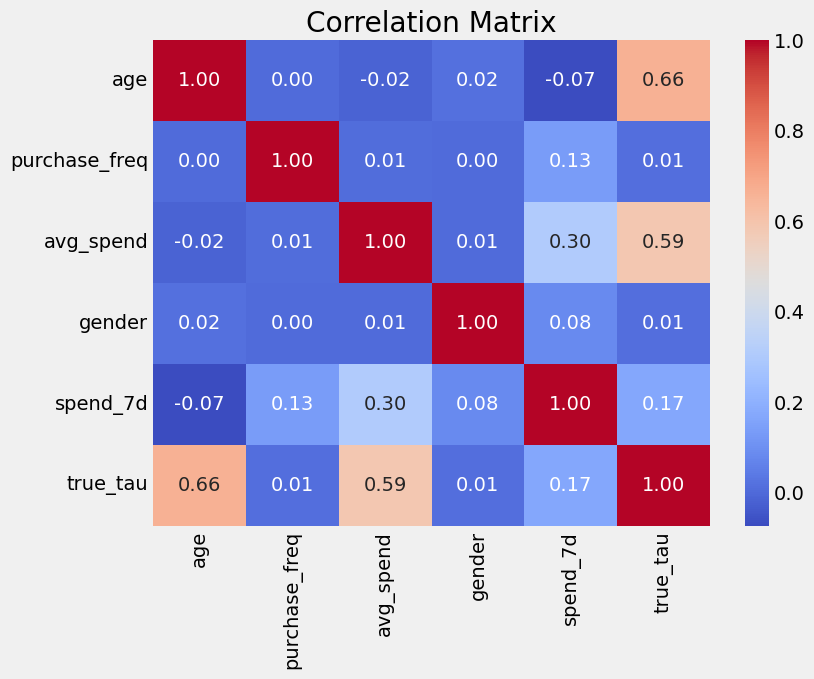

In [40]:

corr = df[['age', 'purchase_freq', 'avg_spend', 'gender', 'spend_7d', 'true_tau']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Average spend by region and treatment:
     region  treatment   spend_7d
0     Rural          0  19.738805
1     Rural          1  43.676729
2  Suburban          0  21.928164
3  Suburban          1  45.140243
4     Urban          0  23.404308
5     Urban          1  47.072767


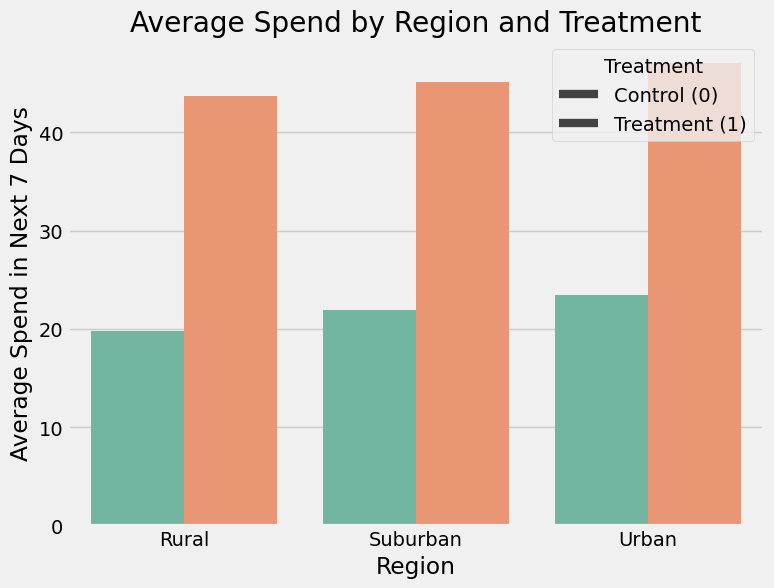

In [42]:

# -------------------------------------------
# Compute group means
# -------------------------------------------
region_treatment_avg = (
    df.groupby(['region', 'treatment'])['spend_7d']
    .mean()
    .reset_index()
)

print("\nAverage spend by region and treatment:")
print(region_treatment_avg)

# -------------------------------------------
# Plot: side-by-side bars
# -------------------------------------------

plt.figure(figsize=(8,6))

# Make treatment a string for seaborn hue
region_treatment_avg['treatment'] = region_treatment_avg['treatment'].astype(str)

sns.barplot(
    data=region_treatment_avg,
    x='region',
    y='spend_7d',
    hue='treatment',
    palette='Set2'
)

plt.title('Average Spend by Region and Treatment')
plt.ylabel('Average Spend in Next 7 Days')
plt.xlabel('Region')
plt.legend(title='Treatment', labels=['Control (0)', 'Treatment (1)'])
plt.show()


In [43]:
# Encode region as dummy
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)

X = df_encoded.drop(columns=['spend_7d', 'treatment', 'true_tau'])
Y = df_encoded['spend_7d']
T = df_encoded['treatment']
tau_true = df_encoded['true_tau']

X_train, X_test, T_train, T_test, Y_train, Y_test, tau_train, tau_test = train_test_split(
    X, T, Y, tau_true, test_size=0.3, random_state=42
)

In [44]:
cf = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100),
    model_t=RandomForestRegressor(n_estimators=100),
    discrete_treatment=True,
    n_estimators=500,
    min_samples_leaf=50,
    max_depth=10,
    random_state=42
)

cf.fit(Y_train, T_train, X=X_train)


First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


In [45]:
cf.fit(Y_train, T_train, X=X_train)
tau_pred = cf.effect(X_test)

First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


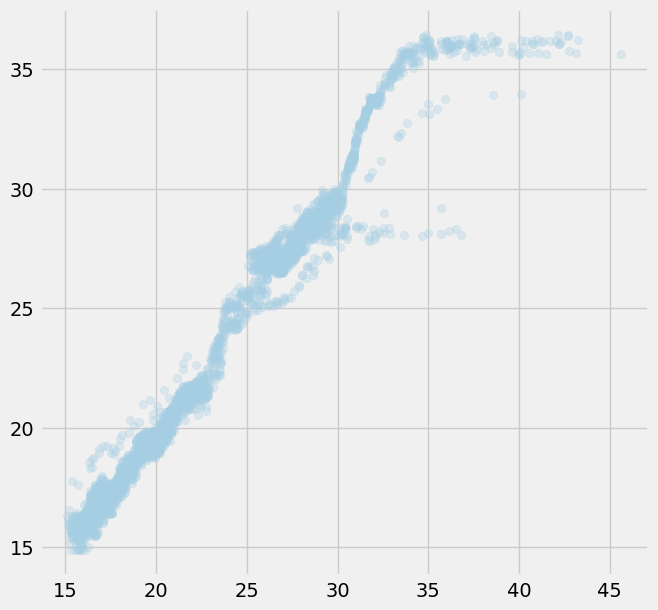

In [ ]:

plt.figure(figsize=(7,7))
plt.scatter(tau_test, tau_pred, alpha=0.3)
plt.show()

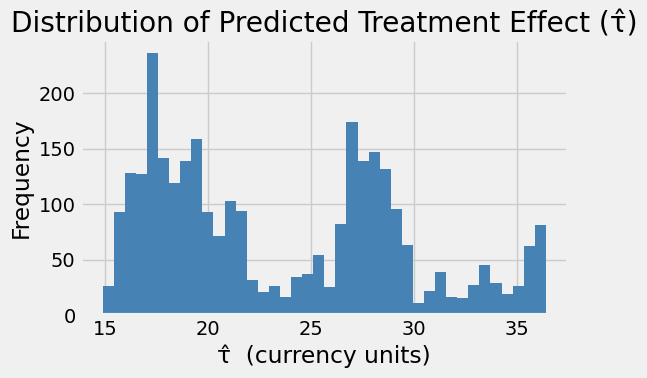



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



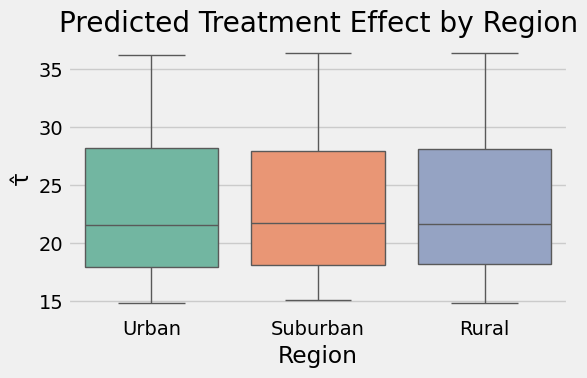

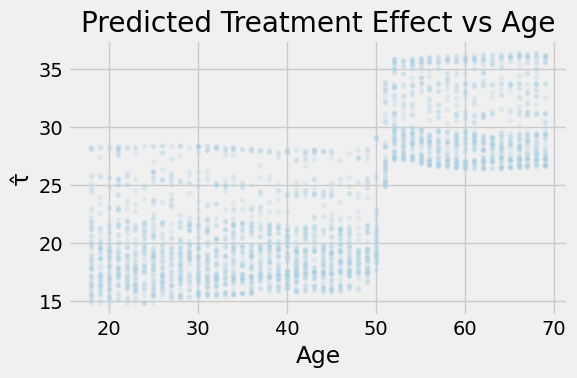

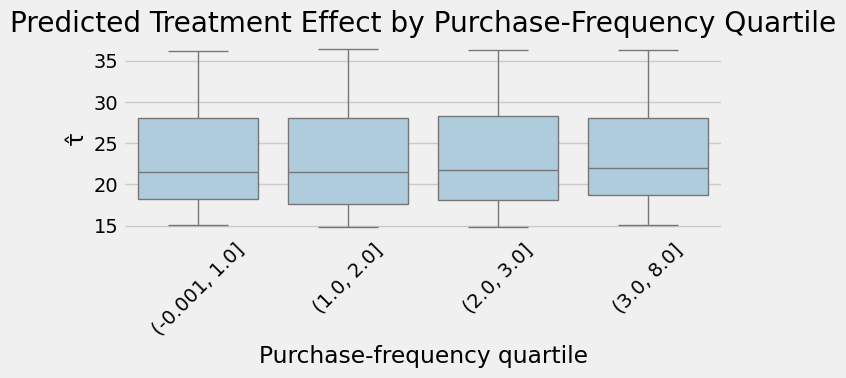

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# 1️⃣  Assemble a test-frame that includes the predictions
# ----------------------------------------------------------
df_test = X_test.copy()                    # DataFrame of covariates
df_test['tau_hat'] = tau_pred              # predicted uplift
df_test['age']      = df.loc[df_test.index, 'age']             # copy age
df_test['region']   = df.loc[df_test.index, 'region']          # copy region
df_test['purchase_freq'] = df.loc[df_test.index, 'purchase_freq']

# ----------------------------------------------------------
# 2️⃣  Plots of τ̂ (predicted uplift)
# ----------------------------------------------------------

# 2-A  Overall distribution of predicted τ̂
plt.figure(figsize=(6,4))
plt.hist(df_test['tau_hat'], bins=40, color='steelblue')
plt.title('Distribution of Predicted Treatment Effect (τ̂)')
plt.xlabel('τ̂  (currency units)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2-B  Box-plot: τ̂ by region
plt.figure(figsize=(6,4))
sns.boxplot(x='region', y='tau_hat', data=df_test, palette='Set2')
plt.title('Predicted Treatment Effect by Region')
plt.xlabel('Region')
plt.ylabel('τ̂')
plt.tight_layout()
plt.show()

# 2-C  Scatter: τ̂ vs age
plt.figure(figsize=(6,4))
sns.scatterplot(x='age', y='tau_hat', data=df_test, alpha=0.25, s=15)
plt.title('Predicted Treatment Effect vs Age')
plt.xlabel('Age')
plt.ylabel('τ̂')
plt.tight_layout()
plt.show()

# 2-D  Box-plot: τ̂ by purchase-frequency quartile
df_test['freq_quartile'] = pd.qcut(df_test['purchase_freq'], q=4, duplicates='drop')
plt.figure(figsize=(7,4))
sns.boxplot(x='freq_quartile', y='tau_hat', data=df_test)
plt.title('Predicted Treatment Effect by Purchase-Frequency Quartile')
plt.xlabel('Purchase-frequency quartile')
plt.ylabel('τ̂')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



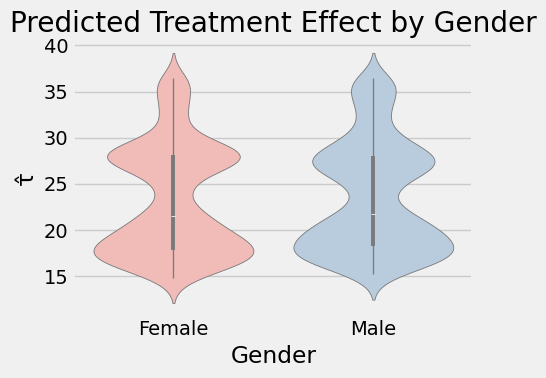

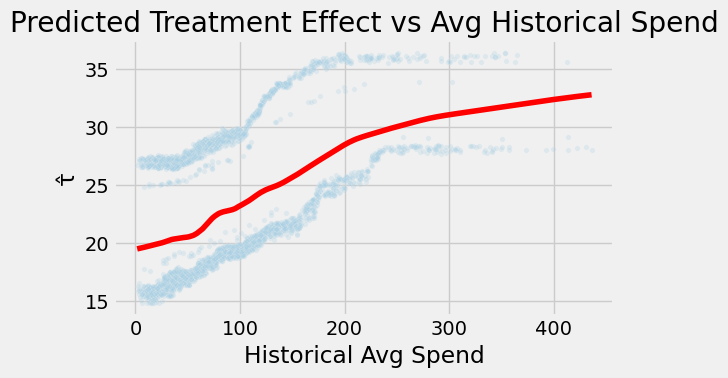

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


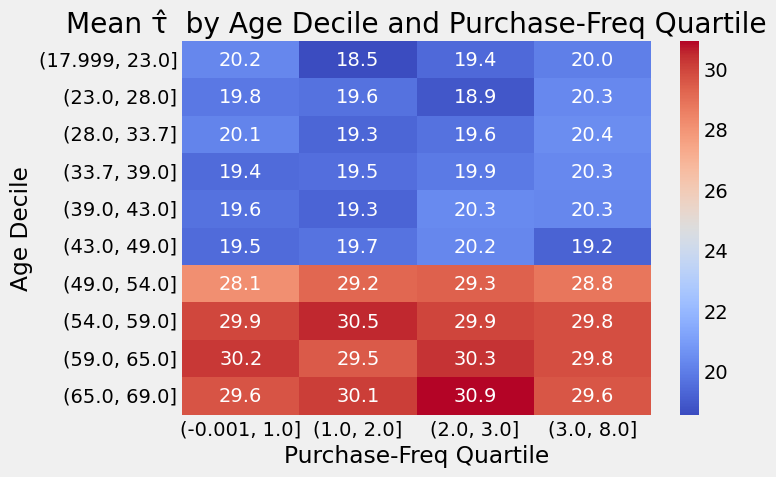

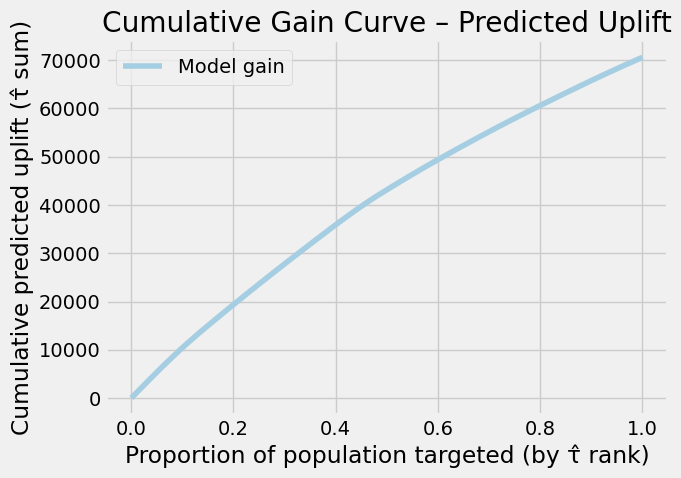

In [66]:
# -----------------------------------------------------------------
# EXTRA VISUAL 1  – Violin plot of τ̂ by gender
# -----------------------------------------------------------------
plt.figure(figsize=(5,4))
# assuming 'gender' is 0/1.  Map to labels for readability:
df_test['gender_lbl'] = df_test['gender'].map({0:'Female', 1:'Male'})
sns.violinplot(x='gender_lbl', y='tau_hat', data=df_test, palette='Pastel1')
plt.title('Predicted Treatment Effect by Gender')
plt.xlabel('Gender')
plt.ylabel('τ̂')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# EXTRA VISUAL 2  – Scatter τ̂ vs average spend (with LOWESS trend)
# -----------------------------------------------------------------
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.figure(figsize=(6,4))
sns.scatterplot(x='avg_spend', y='tau_hat', data=df_test, alpha=0.25, s=15)
# LOWESS smooth line
lowess_curve = lowess(df_test['tau_hat'], df_test['avg_spend'], frac=0.3)
plt.plot(lowess_curve[:,0], lowess_curve[:,1], color='red')
plt.title('Predicted Treatment Effect vs Avg Historical Spend')
plt.xlabel('Historical Avg Spend')
plt.ylabel('τ̂')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# EXTRA VISUAL 3  – 2-D heat-map: age deciles × purchase-freq quartiles
#                   coloured by mean τ̂
# -----------------------------------------------------------------
# create bins
df_test['age_decile'] = pd.qcut(df_test['age'], q=10, duplicates='drop')
df_test['freq_q'] = pd.qcut(df_test['purchase_freq'], q=4, duplicates='drop')

pivot = (df_test
         .groupby(['age_decile','freq_q'])['tau_hat']
         .mean()
         .unstack())

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Mean τ̂  by Age Decile and Purchase-Freq Quartile')
plt.xlabel('Purchase-Freq Quartile')
plt.ylabel('Age Decile')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# EXTRA VISUAL 4  – Cumulative Gain Curve (predicted τ̂‐ranking)
#                  for continuous outcome
# -----------------------------------------------------------------
df_gain = df_test.sort_values('tau_hat', ascending=False).reset_index(drop=True)
df_gain['cum_gain'] = df_gain['tau_hat'].cumsum()
df_gain['prop'] = np.arange(1, len(df_gain)+1) / len(df_gain)

plt.figure(figsize=(7,5))
plt.plot(df_gain['prop'], df_gain['cum_gain'], label='Model gain')
plt.xlabel('Proportion of population targeted (by τ̂ rank)')
plt.ylabel('Cumulative predicted uplift (τ̂ sum)')
plt.title('Cumulative Gain Curve – Predicted Uplift')
plt.legend()
plt.tight_layout()
plt.show()


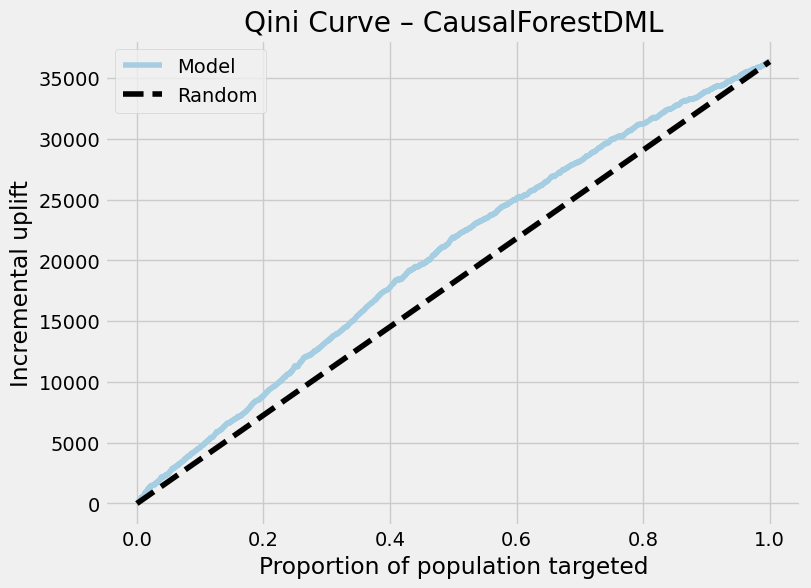

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_eval = pd.DataFrame({
    'y': Y_test.values,          # continuous outcome
    'w': T_test.values,          # treatment 0/1
    'uplift': tau_pred           # predicted ITE
}).sort_values('uplift', ascending=False).reset_index(drop=True)

# cumulative counts
df_eval['n'] = np.arange(1, len(df_eval)+1)
df_eval['cum_treat']   = df_eval['w'].cumsum()
df_eval['cum_control'] = df_eval['n'] - df_eval['cum_treat']
df_eval['cum_y_treat']   = (df_eval['y'] * df_eval['w']).cumsum()
df_eval['cum_y_control'] = (df_eval['y'] * (1-df_eval['w'])).cumsum()

# incremental uplift at each cutoff
df_eval['qini'] = df_eval['cum_y_treat'] - (
    df_eval['cum_y_control'] * df_eval['cum_treat'] /
    df_eval['cum_control'].replace(0, np.nan)
)

# plot curve
plt.figure(figsize=(8,6))
plt.plot(df_eval['n']/len(df_eval), df_eval['qini'], label='Model')
plt.plot([0,1],[0,df_eval['qini'].iloc[-1]],'k--',label='Random')
plt.xlabel('Proportion of population targeted')
plt.ylabel('Incremental uplift')
plt.title('Qini Curve – CausalForestDML')
plt.legend(); plt.show()

In [54]:
# Qini coefficient = area between model and random
area_model  = np.trapz(df_eval['qini'], dx=1/len(df_eval))
area_random = 0.5 * df_eval['qini'].iloc[-1]           # triangle under random line
qini_coeff  = area_model - area_random
print(f"Qini coefficient: {qini_coeff:.2f}")


Qini coefficient: 2155.82


In [64]:
# ----------------------------------------------------------
# 3️⃣  Simple policy value: treat if τ̂ > 0
# ----------------------------------------------------------
treat_policy = tau_pred > 20
gain_policy  = (tau_test[treat_policy]).mean()
gain_random  = tau_test.mean()
print(f"Policy value (treat τ̂>0): {gain_policy:.2f}   |   ATE (random): {gain_random:.2f}")

Policy value (treat τ̂>0): 27.65   |   ATE (random): 23.63
